<a href="https://colab.research.google.com/github/silentfortin/ai-portfolio/blob/main/10-mlops-reputation/notebooks/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import kagglehub
import re
import seaborn as sns
import matplotlib.pyplot as plt

from kagglehub import KaggleDatasetAdapter

from transformers import pipeline
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

In [2]:
file_path = "Twitter_Data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "saurabhshahane/twitter-sentiment-dataset",
  file_path,
)

print("First 5 records:", df.head())

/tmp/ipython-input-2742394549.py:4: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 7.60M/7.60M [00:00<00:00, 46.6MB/s]

Extracting zip of Twitter_Data.csv...


First 5 records:                                           clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0


In [3]:
# negative(-1), neutral(0), and positive(+1)
df.head(5)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [5]:
def remove_emoji(txt):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', txt)

In [6]:
def text_preprocessing(sentiment_df):
    # Create a new column for the processed text
    sentiment_df['processed_text'] = ''

    for index, row in sentiment_df.iterrows():
        text = row['clean_text']
        if not isinstance(text, str):
            # If not a string, replace with empty string or default value
            print(text)
            text = ''
        else:
            text = text.lower()

        # Remove emoji
        text = remove_emoji(text)
        # Remove links
        text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', '', text)
        # Remove usernames
        text = re.sub(r'@[^\s]+', '', text)
        # Replace hashtags with just the word
        text = re.sub(r'#([^\s]+)', r'\1', text)
        # Fix multiple white spaces to a single space
        text = re.sub(r'[\s]+', ' ', text)
        # Remove words shorter than 4 characters and strip spaces
        text = re.sub(r'\W*\b\w{1,3}\b', '', text)
        text = text.strip()

        # Save the cleaned text in the DataFrame
        sentiment_df.at[index, 'processed_text'] = text


In [7]:
# Df cleaning
text_preprocessing(df)

nan
nan
nan
nan


In [8]:
df.head(50)

,clean_text,category,processed_text
0,when modi promised “minimum government maximum...,-1.0,when modi promised “minimum government maximum...
1,talk all the nonsense and continue all the dra...,0.0,talk nonsense continue drama will vote modi
2,what did just say vote for modi welcome bjp t...,1.0,what just vote modi welcome told rahul main ca...
3,asking his supporters prefix chowkidar their n...,1.0,asking supporters prefix chowkidar their names...
4,answer who among these the most powerful world...,1.0,answer among these most powerful world leader ...
5,kiya tho refresh maarkefir comment karo,0.0,kiya refresh maarkefir comment karo
6,surat women perform yagna seeks divine grace f...,0.0,surat women perform yagna seeks divine grace n...
7,this comes from cabinet which has scholars lik...,0.0,this comes from cabinet which scholars like mo...
8,with upcoming election india saga going import...,1.0,with upcoming election india saga going import...
9,gandhi was gay does modi,1.0,gandhi does modi


In [9]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, tokenizer=model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


In [10]:
label = sentiment_pipeline(['kiya tho refresh maarkefir comment karo', 'You\'re handsome'])
label

[{'label': 'neutral', 'score': 0.8653273582458496},
 {'label': 'positive', 'score': 0.9465565085411072}]

# Test on dataset

In [11]:
df['category'] = df['category'].replace({-1: 'negative', 0: 'neutral', 1: 'positive'})

In [12]:
df.isna().sum()

,0
clean_text,4
category,7
processed_text,0


In [13]:
# Drop rows with missing values
df.dropna(subset=['clean_text', 'category'], inplace=True)

In [14]:
df.isna().sum()

,0
clean_text,0
category,0
processed_text,0


In [15]:
# Display some stats
print(df['category'].value_counts())

category
positive    72249
neutral     55211
negative    35509
Name: count, dtype: int64


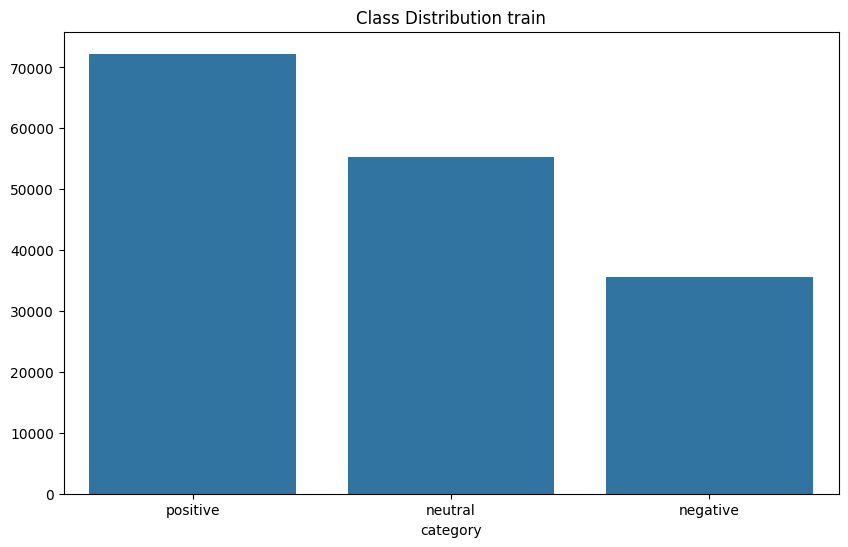

In [16]:
dist = df['category'].value_counts()
def distribution_plot(x, y, name):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=x, y=y)
    plt.title(name)
    plt.show()

distribution_plot(x=dist.index, y=dist.values, name='Class Distribution train')

In [17]:
df.shape

(162969, 3)

In [18]:
sample_text = df[:300]

In [19]:
sample_text.shape

(300, 3)

In [20]:
def get_sentiment(text):
  return(sentiment_pipeline(text)[0]['label'])

In [21]:
#sample_text['RoBerta'] = df['processed_text'].apply(get_sentiment)

In [22]:
def predict_sentiment_batch(df, text_column="processed_text", batch_size=32):
    results = []
    for i in tqdm(range(0, len(df), batch_size)):
        batch_texts = df[text_column].iloc[i:i+batch_size].tolist()
        preds = sentiment_pipeline(batch_texts)
        results.extend([p['label'] for p in preds])
    return results

# just for test, need to extend on all date
df["roberta_pred"] = predict_sentiment_batch(df)


100%|██████████| 5093/5093 [24:01<00:00,  3.53it/s]



📊 Report di classificazione:
              precision    recall  f1-score   support

    negative       0.39      0.64      0.48     35509
     neutral       0.46      0.67      0.54     55211
    positive       0.79      0.26      0.39     72249

    accuracy                           0.48    162969
   macro avg       0.54      0.52      0.47    162969
weighted avg       0.59      0.48      0.46    162969



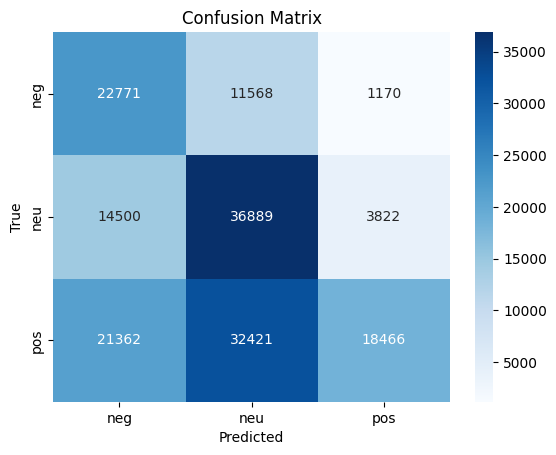

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

print("\n📊 Report di classificazione:")
print(classification_report(df["category"], df["roberta_pred"], zero_division=0))

cm = confusion_matrix(df["category"], df["roberta_pred"], labels=["negative", "neutral", "positive"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["neg","neu","pos"], yticklabels=["neg","neu","pos"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [24]:
errors = df[df["category"] != df["roberta_pred"]]
print(errors.sample(5)[["processed_text", "category", "roberta_pred"]])


                                           processed_text  category  \
116649   modi tells ‘congress culture’ ruined uttarakhand   neutral   
106538  talk about economy ‘pakistan still counting de...  negative   
37502                                  because modi hater   neutral   
32159   maam just realize every bank account this time...  positive   
19184   indian mystics study stars tarot cards predict...  positive   

       roberta_pred  
116649     negative  
106538      neutral  
37502      negative  
32159       neutral  
19184       neutral  
